In [1]:
import mosfit
import numpy as np
import time
import swyft

import matplotlib.pyplot as plt

import astropy.cosmology as cosmo
import astropy.units as u

from astropy.cosmology import z_at_value
from gwtoolbox import tools_earth
from scipy.stats import truncnorm

**Utility Methods**

In [2]:
def jansky(mab):
    return 10**((8.9-mab)/2.5)

**Class Methods and Features**

*Gravitational Wave Generator*

In [3]:
def gwtoolbox_gen(H0_true):
    Om0 = 0.31
    T0 = 2.725
    # generate desired cosmology
    cosmos = tools_earth.set_cosmology(None, H0_true, Om0, T0)
    # R0, tau, m_mean, m_sclae, m_low, m_high, chi_sigma
    # R0: merger rate [/yr/Gpc3] 
    # tau: Delay time from formation to merger [Gyr]
    # mass mean, standard deviation, low, high [solar masses]
    # dispersion of effective spin
    # be sure to keep these consistent with MOSFIT!
    # find sauce to motivate the selected values
    BNS_par = [300,3,1.4,0.5,1.1,2.5,0.1]
    # summon the desired tool (LIGO)
    Tools = tools_earth.Tools(detector_type='ligo', event_type='nsns',\
                              population=BNS_par, cosmos=cosmos)
    # set generator parameters
    time_obs = 60*24*365 # units of minutes of observation
    rho_cri = 8 # signal-to-noise ratio cutoff
    tot_num = Tools.total_number(time_obs, rho_cri)
    # returns keys 'z','D','m1','m2','χ','dz','dm1','dm2','dχ','dD','dtb'
    list_det = Tools.list_with_errors_df(time_obs, rho_cri, dtp=True)
    params = [list_det['z'], list_det['D'], list_det['m1'], list_det['m2'],\
              list_det['χ'], list_det['dz'], list_det['dm1'], list_det['dm2'],\
              list_det['dχ'], list_det['dD'], list_det['dtb']]
    return params

I will want to turn this into a one-off O4 generator as follows: 
1. Generate all 20-something gravitational waves for one year
2. determine the fraction which have GW detections
3. use mosfit to determine the fraction which have EM detections

For the time being, let us take a single event and run our forward model for this event

In [4]:
o4_all = gwtoolbox_gen(70)

In [5]:
# z, DL, m1, m2, etc...
single_event = np.array(o4_all).T[0]

In [12]:
single_event

array([7.72063605e-02, 3.49698509e+02, 1.96132640e+00, 1.41396710e+00,
       2.37410262e-01, 3.86031803e-02, 9.80663198e-02, 7.06983552e-02,
       3.62016785e-04, 1.84098413e+02, 6.60000000e-02])

At this stage, I sample all of my favorite parameters from their priors. In the baby model, I will only sample $H_0$ and $v$, while leaving all other parameters fixed.

Rather than using GWToolBox for now, I'm going to create some very simple kilonovae from scratch and create a method to determine whether or not they were detected.

**Distance-Angle Probability Distribution Function**

In [5]:
def H(x):
    """
    Heaviside step function
    """
    return 1/(1+np.exp(-50*x))

In [6]:
def delta1(D_0, m1, m2):
    """
    Uncertainty function one
    """
#     m = 1.4
    M = ((m1*m2)**(3/5)/(m1+m2)**(1/5))**(5/6)
    r_0 = 6.5e3*M
    eps = 0.74
    sig = 1.03
    rad = np.sqrt((1+eps*np.cos(4*56*np.pi/180))/(sig*(1-eps**2)))
    return D_0*rad/r_0


def delta2(D_0, m1, m2):
    """
    Uncertainty function two
    """
#     m = 1.4
    M = ((m1*m2)**(3/5)/(m1+m2)**(1/5))**(5/6)
    r_0 = 6.5e3*M
    eps = 0.74
    sig = 1.03
    rad = np.sqrt((1-eps*np.cos(4*56*np.pi/180))/(sig*(1-eps**2)))
    return D_0*rad/r_0

In [7]:
def dp(D_0, D, v_0, v, m1, m2):
    d1 = delta1(D_0, m1, m2) # 0.1
    d2 = delta2(D_0, m1, m2) # 0.057
    M = ((m1*m2)**(3/5)/(m1+m2)**(1/5))**(5/6)
    Dmax = 6.5e3*M
#     d1 = 0.103
#     d2 = 0.057
#     print(d1, d2)
    Dd = D/D_0
    e = np.exp(-1/(2*d1**2) * (v/Dd - v_0)**2 - 
              1/(2*d2**2)*((1+v**2)/(2*Dd) - (1+v_0**2)/2)**2)
    return Dd**2*e*H(D/D_0)*H(Dd)*H(Dmax/D_0 - Dd)*H(1-v**2)

In [8]:
def pDV_dist(D0, v0, m1, m2):
    thetaline = np.linspace(0, np.pi/2, 100)
    vline = np.cos(thetaline)
    dline = np.linspace(D0/3, D0*5, 100)
    vv, dd = np.meshgrid(vline, dline)
    positions = np.vstack([vv.ravel(), dd.ravel()])
    values = np.vstack([vline, dline])
    pmesh = dp(D0, dd, v0, vv, m1, m2)
    pmesh /= pmesh.max()
    return pmesh, values, positions, vline, dline

In [9]:
pdist = pDV_dist(400, 0.3, 1.4, 1.2)

In [10]:
pflat = pdist[0].ravel()
valflat = pdist[1].ravel()
posflat = pdist[2].ravel()

In [11]:
vt = 0.1
vloc = np.abs(pdist[3] - vt).argmin()
p_at_v = pdist[0][...,vloc]

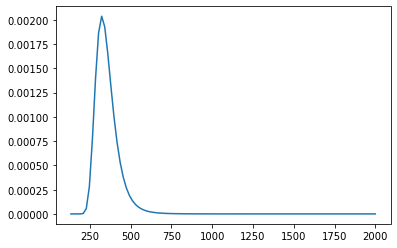

In [12]:
plt.plot(pdist[-1], p_at_v)
plt.show()

In [13]:
dt = 200

In [14]:
dloc = np.abs(pdist[1][1] - dt).argmin()

In [15]:
dp(210, dt, 0.1, vt, 1.4, 1.4)

0.7840179676010272

**Generating True Events from Scratch**

The idea here is to have two events at exactly the same distance. The only thing which will distinguish between them is their inclination angle

In [87]:
# assume a true value for the Hubble constant
u_true = cosmo.FlatLambdaCDM(70, 0.3)
# set the true redshift of the events
# z_true = 0.031
z_true = 0.1
# calculate the true distance of the events
d_true = u_true.luminosity_distance(z_true).value
m1_true = 1.4
m2_true = 1.4

In [88]:
# z, dl, m1, m2, v
# event_list = [[z_true, d_true, m1_true, m2_true, 0.1, False],[z_true, d_true, m1_true, m2_true, 0.9, True]]
# let's leave two events for later due to the complications of observed and unobserved events being put together
# event_list = [[z_true, d_true, m1_true, m2_true, 0.1, False],[z_true, d_true, m1_true, m2_true, 0.9, True]]
# event_list = [[z_true, d_true, m1_true, m2_true, 0.1, False]]
event_list = [[z_true, d_true, m1_true, m2_true, 0.9, True]]
det_obs = [event[-1] for event in event_list]

In [89]:
det_obs

[True]

In [90]:
# I am still unsure as to the effect of the limiting magnitude here, besides setting a cutoff

my_fitter = mosfit.fitter.Fitter(quiet=False, test=True, offline=False)
# my_fitter = mosfit.fitter.Fitter(limiting_magnitude=23.3, quiet=False, test=True, offline=False)

In [77]:
fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
              "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
              "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": 1.188,\
              "q": 0.92, "cos_theta": 0.5, "cos_theta_open": 0.707107,\
              "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
              "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
              "temperature_shock": 100, "lumdist": 400, "redshift": 0.9}
              
# ebv: host galaxy extinction, sampled from RA/DEC
# rvhost: host galaxy extinction (?)
# frad: no idea
# nnhost: no idea
# texplosion: when the explosion occurs (?)
# temperature: surface temperature of NS (?)
# kappa_red: no idea
# kappa_blue: no idea
# kappagamma: no idea
# Mchirp: the chirp mass
# q: M1/M2 ratio
# cos_theta: orientation angle
# cos_theta_open: no idea
# disk_frac: no idea
# radius_ns: radius of NS (?)
# alpha: no idea
# Mtov: no idea
# cos_theta_cocoon: no idea
# tshock: time of shock (?)
# temperature_shock: temperature of shock (?)

In [78]:
def light_curve(fitfunc, fixed_params):
    """
    Given a fit function and a list of fixed parameters, generates a light curve using mosfit 
    and returns whether a detection is made.
    args:
    - fixed_params: dictionary of fixed parameters
    returns:
    - detection: bool
    
    To do: this should also take the observing time window in units of days after the explosion,
    the magnitude cutoff of each observing band, and probably something else.
    """
    # convert dictionary to list
    # consider turning this into a utility function
    fpar = ["ebv", fixed_params['ebv'], "rvhost", fixed_params['rvhost'],\
            "frad", fixed_params['frad'], "nnhost", fixed_params['nnhost'],\
            "texplosion", fixed_params['texplosion'],\
            "temperature", fixed_params['temperature'],\
            "kappa_red", fixed_params['kappa_red'],\
            "kappa_blue", fixed_params['kappa_blue'],\
            "kappagamma", fixed_params['kappagamma'],\
            "Mchirp", fixed_params['Mchirp'],\
            "q", fixed_params['q'], "cos_theta", fixed_params['cos_theta'],\
            "cos_theta_open", fixed_params['cos_theta_open'],\
            "disk_frac", fixed_params['disk_frac'],\
            "radius_ns", fixed_params['radius_ns'],\
            "alpha", fixed_params['alpha'], "Mtov", fixed_params['Mtov'],\
            "cos_theta_cocoon", fixed_params['cos_theta_cocoon'],\
            "tshock", fixed_params['tshock'], "temperature_shock",\
            fixed_params['temperature_shock'],\
            "lumdist", fixed_params['lumdist'], "redshift", fixed_params['redshift']]
    # create kwargs dict using fixed_params
    kwargs = dict(events=[], models=['bns_generative'],\
              max_time=4, band_list="z", band_systems="AB", iterations=0, num_walkers=1,\
              smooth_times=4, suffix="jupyter_test", user_fixed_parameters=fpar,\
             quiet=True)
    # run mosfit
    entries, ps, lnprobs = my_fitter.fit_events(**kwargs)
    # get observed magnitudes
    # see if there is any way to do this without a for loop
    obs_mags = []
    for entry in entries[0][0]['photometry']:
        if entry['system'] == 'AB':
            obs_mags += [float(entry['magnitude'])]
#     print(obs_mags)
    # magnitude probability of detection
    sig10 = 23.3
    mclip_a = 0
    mclip_b = 1
    m_std = abs((jansky(sig10)) / 10)
    a, b = mclip_a / m_std, mclip_b / m_std
    v = truncnorm(a,b)
    # see if the lowest magnitude beats our probabilistic detection threshold
    flux_obs = jansky(np.array(obs_mags))
    print(flux_obs)
    # test plot
#     x = np.linspace(20, 30)
#     plt.plot(x, v.cdf(jansky(x)/m_std))
#     plt.show()
    
    obs_probs = v.cdf(flux_obs/m_std)
    mprob = np.random.uniform(0,1)
    detect = mprob < obs_probs
    pobs = max(obs_probs)
#     print(obs_mags)
#     print(obs_probs)
#     print(detect)
#     detect = min(obs_mags) <= sig10
#     print(True in detect)
    return (True in detect), pobs
#     return detect

In [79]:
# set simulator parameters
DEVICE = 'cpu'  # replace with 'cpu' if no GPU is available
Ntrain = 20
k = 1 # number of free event parameters
Nev = len(event_list) # number of events
Npar = 1 + k * Nev # number of free parameters (event parameters plus H0)

In [80]:
xee = [1,2,3]
xee[1:3]

[2, 3]

In [81]:
def nobs_forward(H0, ve, event):
    # get free event parameters
    v0 = np.cos(ve[0])
    # use results from GWToolbox to get the true DL, M1, M2
    TDL = event[1]
    M1 = event[2]
    M2 = event[3]
    # derived mass quantities
    Q = M1/M2
    Mchirp = ((M1*M2)**3/(M1+M2))**(1/5)
    # create a cosmology from H0 and generate the true redshift
    # in this sample cosmology
    # assume omega_m=0.31 (make sure this is consistent with GWTB)
    universe = cosmo.FlatLambdaCDM(H0, 0.3)
    # "z in cosmology"
    ZIC = z_at_value(universe.luminosity_distance, TDL*u.Mpc)
    fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
              "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
              "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": Mchirp,\
              "q": Q, "cos_theta": v0, "cos_theta_open": 0.707107,\
              "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
              "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
              "temperature_shock": 100, "lumdist": TDL, "redshift": ZIC}
    det, pobs = light_curve(my_fitter, fixed_params)
    return det, 1

In [91]:
def obs_forward(H0, ve, event):
    # get free event parameters
    v0 = np.cos(ve[0])
    # use results from GWToolbox to get the true DL, M1, M2
    TZ = event[0]
    TDL = event[1]
    M1 = event[2]
    M2 = event[3]
    # derived mass quantities
    Q = M1/M2
    Mchirp = ((M1*M2)**3/(M1+M2))**(1/5)
    # create a cosmology from H0 and generate the true redshift
    # in this sample cosmology
    # assume omega_m=0.31 (make sure this is consistent with GWTB)
    universe = cosmo.FlatLambdaCDM(H0, 0.3)
    # "distance in cosmology"
    DIC = universe.luminosity_distance(TZ).value
    # probability density of given cosmology-assigned distance at sampled angle v0
    dprob = dp(event[1], DIC, event[4], v0, event[2], event[3])
    print("dprob:", dprob)
    # I also need to calculate the probability of this distance being allowed
    # and return that probability to be used in the summary statistic
    fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
              "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
              "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": Mchirp,\
              "q": Q, "cos_theta": v0, "cos_theta_open": 0.707107,\
              "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
              "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
              "temperature_shock": 100, "lumdist": DIC, "redshift": TZ}
    det, pobs = light_curve(my_fitter, fixed_params)
    return det, pobs*dprob

In [96]:
def forward(v):
    # get terms from input vector
    H0 = v[0]
    print("Input Vector:", H0, np.cos(v[1]))
    det_list = []
    i = 1
    N = 0
    p = 1
    for event in event_list:
        ve = v[N+1:i+k*i]
        N = i+k*i
        i += 1
        if event[-1] is True:
            det, pobs = obs_forward(H0, ve, event)
        else:
            det, pobs = nobs_forward(H0, ve, event)
        det_list += [det]
        p *= pobs
    if det_list == det_obs:
        x = [p]*Npar
    else:
        x = [0.0]*Npar
    return dict(x=x)

dprob: 0.9999251537724895

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading mod

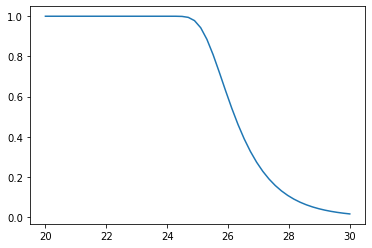

[30.66198601881151, 25.734276025628375, 26.301278258880956, 26.640511156898086]
[0.00906017 0.71194756 0.47144604 0.35527345]
[False  True  True  True]


{'x': [0.7118942754947422, 0.7118942754947422]}

In [93]:
forward([70, np.arccos(0.9)])

**Congratulations!**
You now have a working forward model! With the data you've given it, it is only informative for priors which stretch beyond $h=0.8$, so let's make sure to define a broad prior.

Let's see if my simulator is the problem by writing in a simple model

**Single-Event Inference with TMNRE**

In [97]:
# a TMNRE prior function take a random variable between 0 and 1 and produces an input vector from a prior of your choice

def pfunc(u):
    H0 = 50 * u[0] + 50
#     v = np.cos(np.pi / 2 * u[1])
    theta = np.pi / 2 * u[1]
    return np.array([H0, theta])

Creating new store.
Store: Adding 17 new samples to simulator store.
Input Vector: 54.58699380770923 0.6504752257412871
dprob: 5.214616865384397e-12

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alph

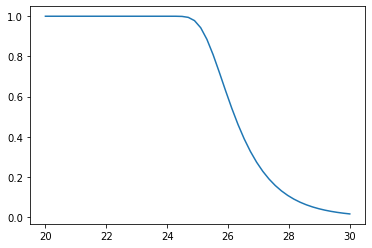

[31.20593544607921, 26.375234864683748, 27.051949347327273, 27.53224040054219]
[0.00548988 0.44394839 0.2477398  0.16072174]
[ True  True  True  True]
Input Vector: 97.63006552780041 0.4859919267624497
dprob: 0.0005197049890781028

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading mo

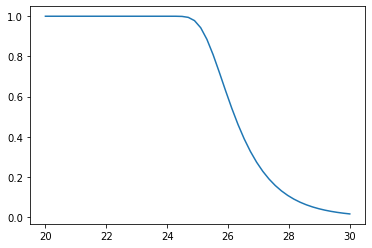

[29.9518880703717, 25.192900547995993, 25.972814022718946, 26.59502363987869]
[0.0174241  0.91974376 0.6062594  0.36936188]
[False  True  True  True]
Input Vector: 56.39345070963806 0.46639078577516957
dprob: 3.556944937368725e-20

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading mo

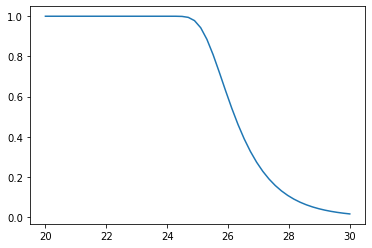

[31.14492829957081, 26.394259544961862, 27.187084771405434, 27.828088935446758]
[0.00580717 0.43706695 0.21953928 0.12273848]
[False False False False]
Input Vector: 65.90635858043142 0.2900613629747827
dprob: 4.195608493570584e-27

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading m

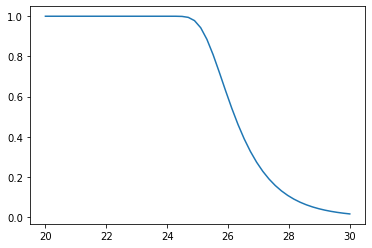

[30.81839510916245, 26.129626142420577, 27.023979237405342, 27.822838918172117]
[0.00784468 0.53958178 0.25398476 0.12332867]
[False  True  True False]
Input Vector: 51.580388550688276 0.5165917397059792
dprob: 3.690371884959091e-20

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading 

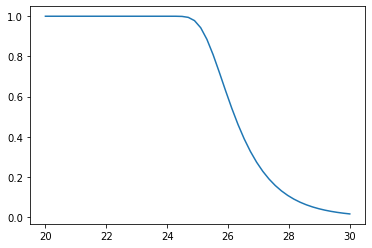

[31.335518508527187, 26.563423904024237, 27.323378147238486, 27.917026232508846]
[0.00487225 0.37942019 0.19419224 0.11315297]
[False False False False]
Input Vector: 66.66349581512699 0.7863516550697468
dprob: 0.021949641051986015

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading m

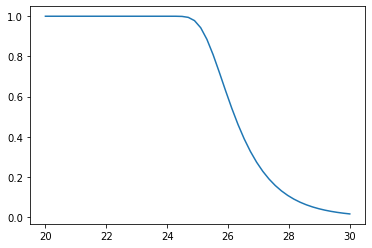

[30.768517872117762, 25.882574630947772, 26.493655703975723, 26.88811884191848]
[0.00821344 0.64595202 0.40241949 0.28643545]
[False  True False False]
Input Vector: 81.05971760323823 0.8540594797621096
dprob: 0.16884470416598968

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading mod

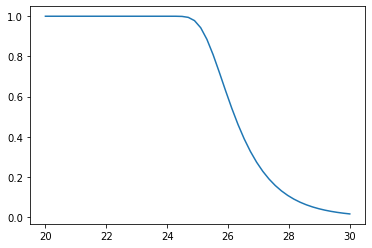

[30.343371564524073, 25.4323474091772, 26.0163772259914, 26.37672509934438]
[0.01214995 0.8393864  0.58739135 0.44340649]
[False  True  True  True]
Input Vector: 81.28597069761797 0.5716828813726594
dprob: 0.00015586158058761475

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading modu

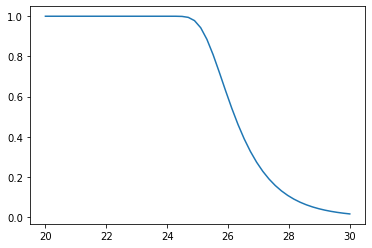

[30.344842962218497, 25.548816944433277, 26.273576411267836, 26.818222502223747]
[0.0121335  0.79243809 0.48204528 0.30455848]
[False  True False False]
Input Vector: 60.014541099282326 0.7239495628633951
dprob: 1.964720892132633e-06

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading

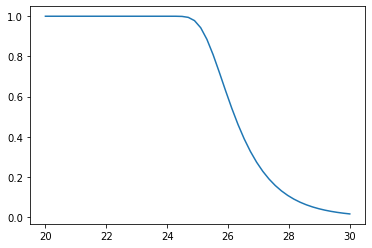

[30.997822808173545, 26.135730015626297, 26.774073481954392, 27.20367542384105]
[0.00664976 0.53706355 0.31652667 0.21629352]
[False False False False]
Input Vector: 87.21660814802519 0.5983768247129359
dprob: 0.020614250137160818

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading mo

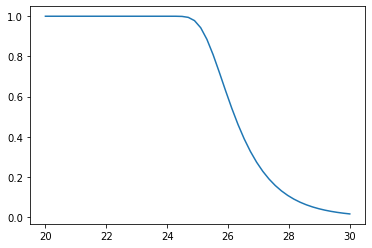

[30.190618610243742, 25.382871687676314, 26.090995326389148, 26.613043347411978]
[0.01398525 0.85801078 0.55566598 0.36372584]
[False  True  True False]
Input Vector: 67.06921978168445 0.8989333602760505
dprob: 0.8311348599798501

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading mod

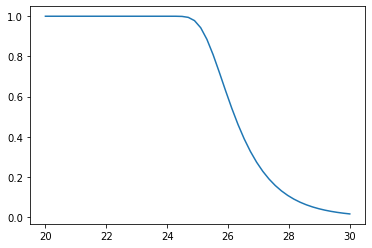

[30.754853339196835, 25.82752870987548, 26.394915021630787, 26.734621261117386]
[0.00831746 0.67042181 0.43683127 0.32757055]
[False False False False]
Input Vector: 89.06828743565127 0.7319464316753005
dprob: 0.43332469707003546

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading mod

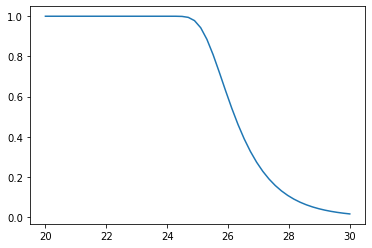

[30.14031060551872, 25.275114844574578, 25.909828668253763, 26.334706378921524]
[0.01464844 0.89511924 0.63389434 0.45887143]
[False  True False False]
Input Vector: 75.13997440392667 0.7244432616061097
dprob: 0.07995493755123247

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading mod

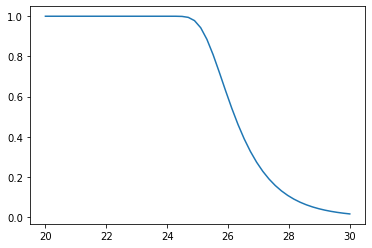

[30.50973871170383, 25.64745392770309, 26.285572103424126, 26.714880393014475]
[0.01042395 0.75020573 0.47743584 0.33322188]
[False  True  True  True]
Input Vector: 54.4835019078334 0.9805089809649145
dprob: 0.046548145304865236

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading modu

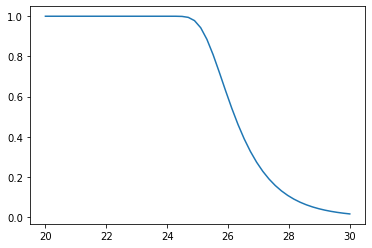

[31.207460453858147, 26.25072749135871, 26.790162972155187, 27.095761006198895]
[0.00548217 0.49090717 0.31211763 0.23824468]
[False  True  True  True]
Input Vector: 88.96147316975143 0.5052910468030423
dprob: 3.91311148037028e-05

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading mo

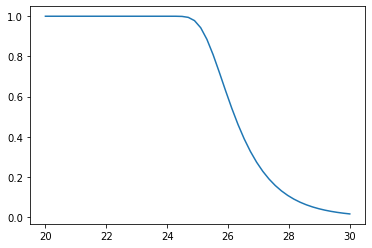

[30.152604636859266, 25.3853671294433, 26.152662170147636, 26.756747223786874]
[0.01448353 0.85709337 0.53011234 0.32133593]
[False False False False]
Input Vector: 63.45657942300116 0.3734300338210262
dprob: 2.5564464576850656e-22

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading m

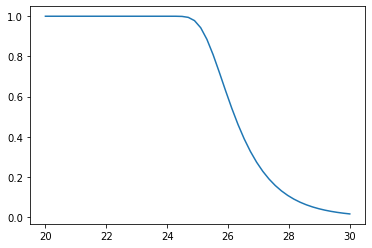

[30.895403041950846, 26.182704242120955, 27.036741872445162, 27.770592749221876]
[0.00730757 0.5179069  0.2511173  0.12935612]
[False False False False]
Input Vector: 57.75723022543051 0.5175307563788356
dprob: 1.1863831714638102e-16

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading

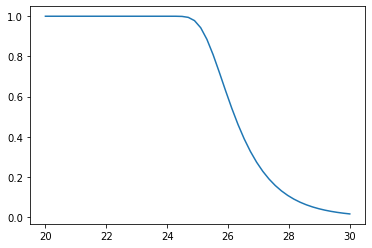

[31.089854667062795, 26.317355619047156, 27.07670157677459, 27.66948827868438]
[0.00610934 0.46536853 0.2423328  0.14185263]
[False False False False]


In [98]:
# simulator = swyft.Simulator(simulator, Npar, sim_shapes = {"x": [Npar]})
# store = swyft.MemoryStore(simulator)

simulator = swyft.Simulator(forward, ["H_0", "\theta"], sim_shapes = {"x": [Npar]})
store = swyft.MemoryStore(simulator)

prior = swyft.Prior(pfunc, Npar)
# prior = swyft.Prior(lambda u: u*50+50, Npar)
store.add(Ntrain, prior)
store.simulate()

In [99]:
store.add(Ntrain, prior)
store.simulate()

In [100]:
# j = 0
# while j<=20:
#     print(dataset.__getitem__(j))
#     j+=1

In [101]:
dataset = swyft.Dataset(Ntrain, prior, store)
post = swyft.Posteriors(dataset)

In [102]:
post.add([(0, 1)], device=DEVICE)
post.train([(0, 1)], max_epochs = 20, nworkers=0)

Training: lr=0.001, Epoch=6, VL=1.387


Input Vector: 70.0 0.15643446504023092
dprob: 1.0124069089640628e-36

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loa

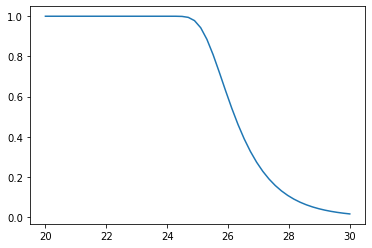

[30.694589398152452, 26.031660143186723, 26.970794626674834, 27.84633188813494]
[0.00879216 0.58082865 0.26626332 0.12070922]
[False  True False False]


In [105]:
v0 = np.array([70, np.pi*0.9/2])
obs0 = forward(v0)

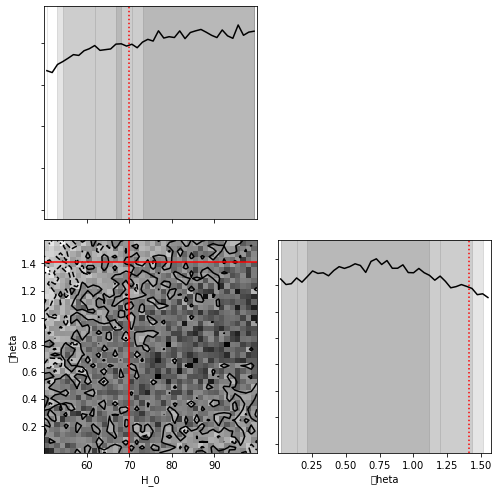

In [106]:
samples = post.sample(100000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);

**Double Event Inference with TMNRE**